In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/Users/purzelrakete/src/github.com/feldberlin/wavenet


In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm

import matplotlib.pyplot as plt

from wavenet import datasets

# Tiny Wavenets

As described in https://fleuret.org/dlc. This is a great start for to investigate wavenet; the model is highly simplified, but since the dataset is also highly simplified, we can fit it even without dilations. Nevertheless, the dataset is just hard enough to excercise the model a bit.

## Dataset

In [3]:
n, m = 30, 5_000
ds = datasets.Tiny(n, m)
trainset = torch.stack([ds[i] for i in range(len(ds))], dim=0)
trainset_mean = torch.mean(trainset.float())
trainset_std = torch.std(trainset.float())

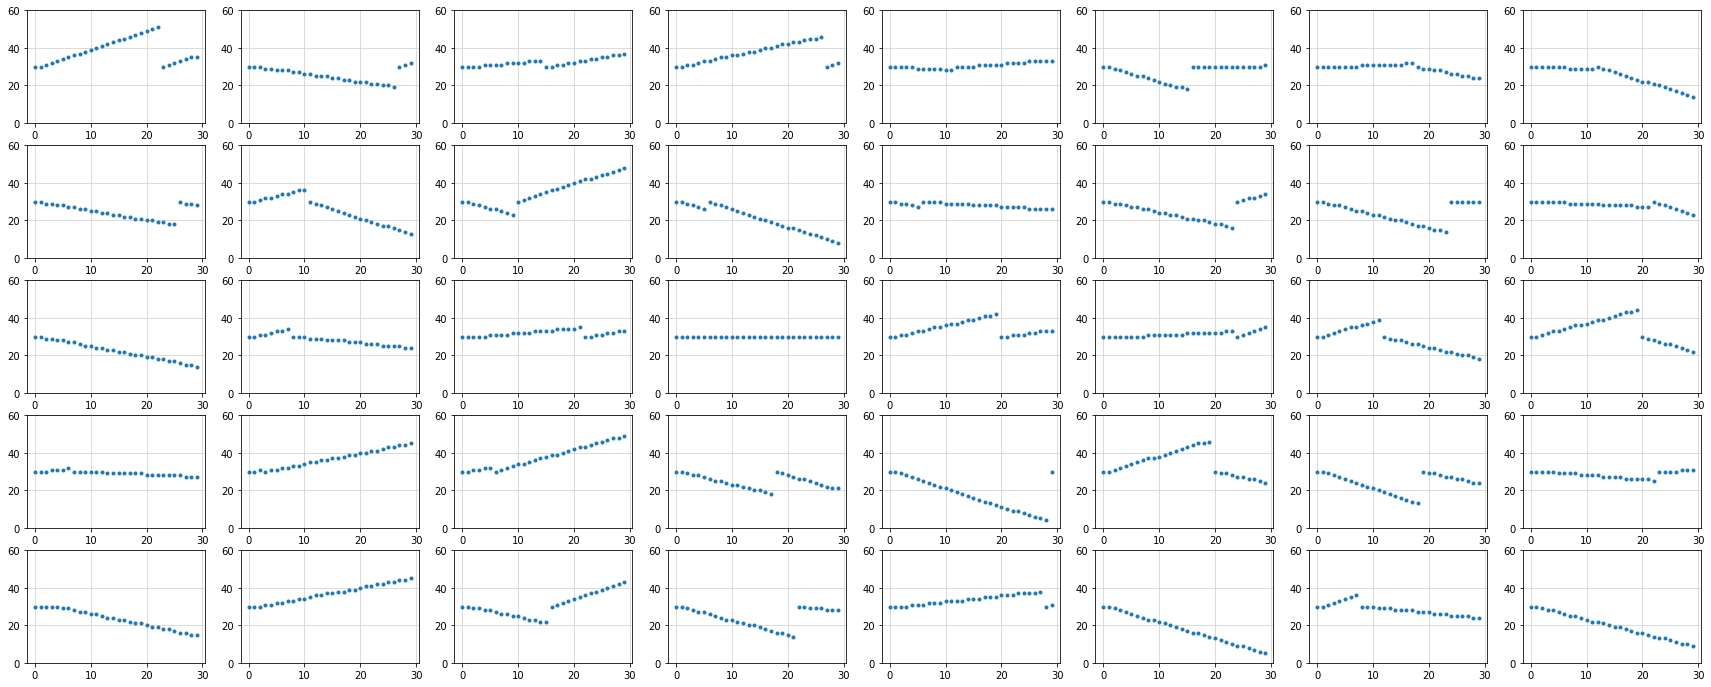

In [4]:
plt.subplots(figsize=(30, 12))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.ylim(0, 2*n)
    plt.grid(color='lightgray')
    plt.plot(torch.arange(n), ds[i].squeeze(), '.')

## Model

In [5]:
class Model(nn.Module):

    def __init__(self, nb_classes, ks = 2, nc = 32):
        super().__init__()
        self.pad = (ks - 1, 0)
        self.conv0 = nn.Conv1d(1, nc, kernel_size = 1)
        self.conv1 = nn.Conv1d(nc, nc, kernel_size = ks)
        self.conv2 = nn.Conv1d(nc, nc, kernel_size = ks)
        self.conv3 = nn.Conv1d(nc, nc, kernel_size = ks)
        self.conv4 = nn.Conv1d(nc, nc, kernel_size = ks)
        self.conv5 = nn.Conv1d(nc, nb_classes, kernel_size = 1)

    def forward(self, x):
        x = F.relu(self.conv0(F.pad(x, (1, -1))))
        x = F.relu(self.conv1(F.pad(x, self.pad)))
        x = F.relu(self.conv2(F.pad(x, self.pad)))
        x = F.relu(self.conv3(F.pad(x, self.pad)))
        x = F.relu(self.conv4(F.pad(x, self.pad)))
        x = self.conv5(x)
        return x.permute(0, 2, 1).contiguous()

## Train

In [6]:
n_epochs = 200
batch_size = 64

In [7]:
def train(model, n_epochs):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # training
    best_loss = np.Inf
    losses = []
    loader = tqdm((e, (it, b)) for e in range(n_epochs) for (it, b) in enumerate(trainset.split(batch_size)))
    for epoch, (it, sequences) in loader:
        input = (sequences - trainset_mean) / trainset_std
        output = model(input)
        loss = F.cross_entropy(
            output.view(-1, output.size(-1)),
            sequences.view(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().numpy())
        
        if loss < best_loss:
            best_loss = loss
        if it % 20 == 0:
            loader.set_description(f'{epoch+1}:{it:03d} loss {loss.item():.5f} best loss {best_loss.item():.5f}')
            
    return losses

200:060 loss 0.63688 best loss 0.59086: : 15800it [02:47, 94.27it/s]


Text(0.5, 1.0, 'cross entropy. best: 0.590863823890686')

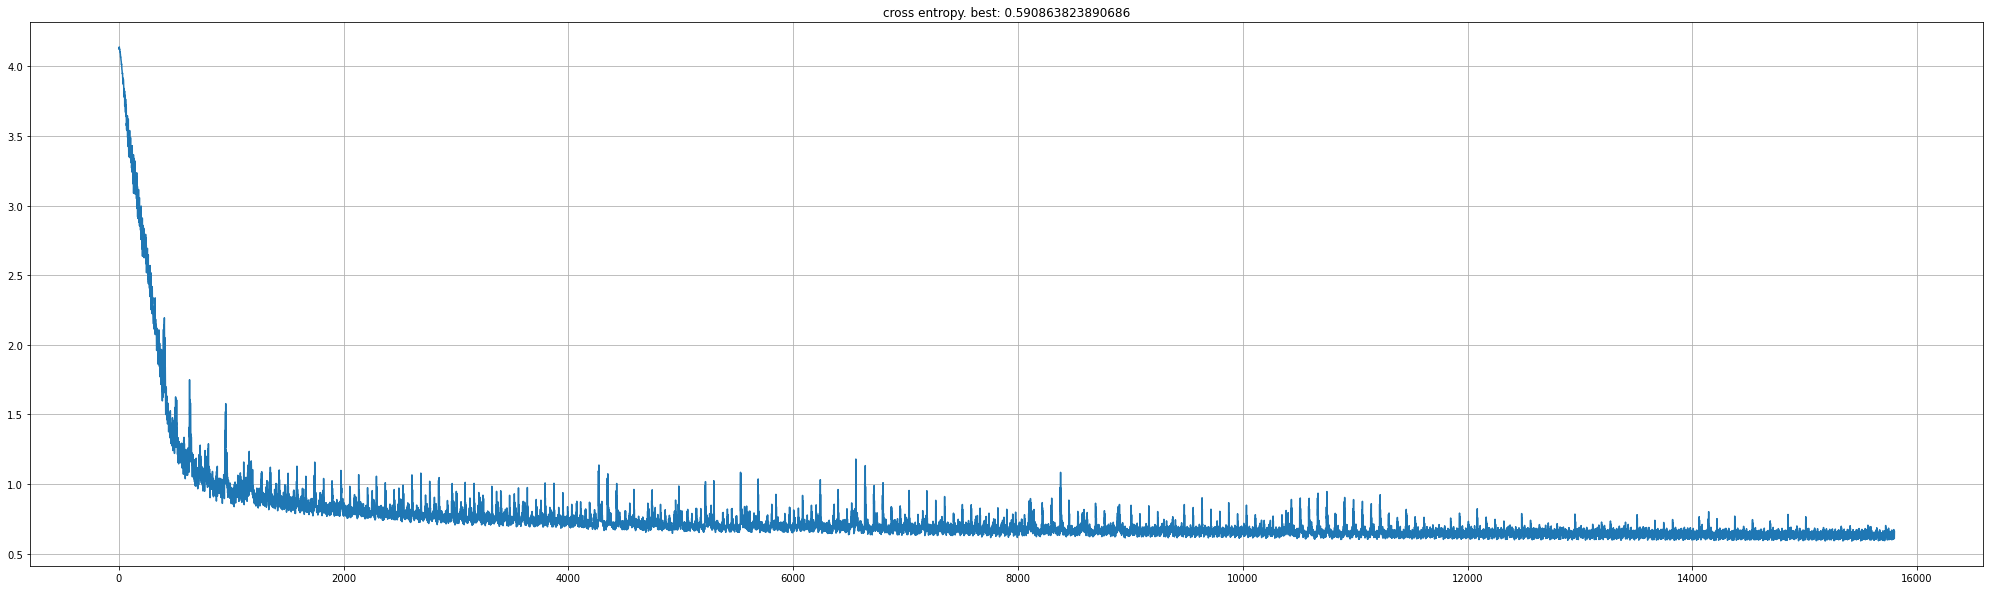

In [8]:
model = Model(2*n)
losses = train(model, n_epochs)

plt.figure(figsize=(35, 10))
plt.plot(losses)
plt.grid()
plt.title(f'cross entropy. best: {min(losses)}')

## Sample

In [9]:
def sample(model, n_samples = 48):
    generated = trainset.new_zeros((n_samples,) + trainset.size()[1:])
    flat = generated.view(generated.size(0), -1)

    # sampling
    for t in range(flat.size(1)):
        input = (generated.float() - trainset_mean) / trainset_std
        output = model(input)
        logits = output.view(flat.size() + (-1,))[:, t]
        dist = torch.distributions.categorical.Categorical(logits = logits)
        flat[:, t] = dist.sample()
        
    return generated

In [10]:
generated = sample(model)

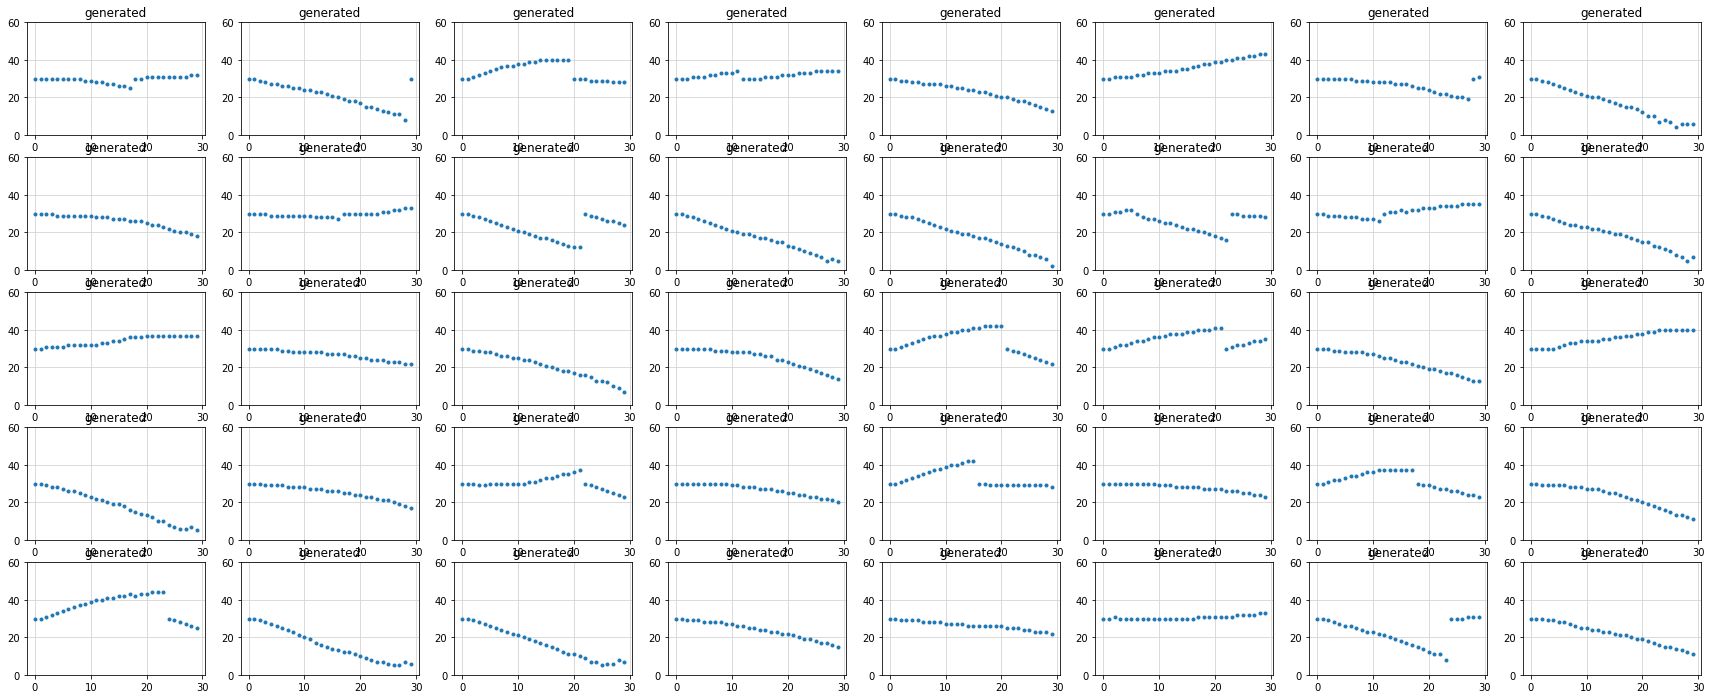

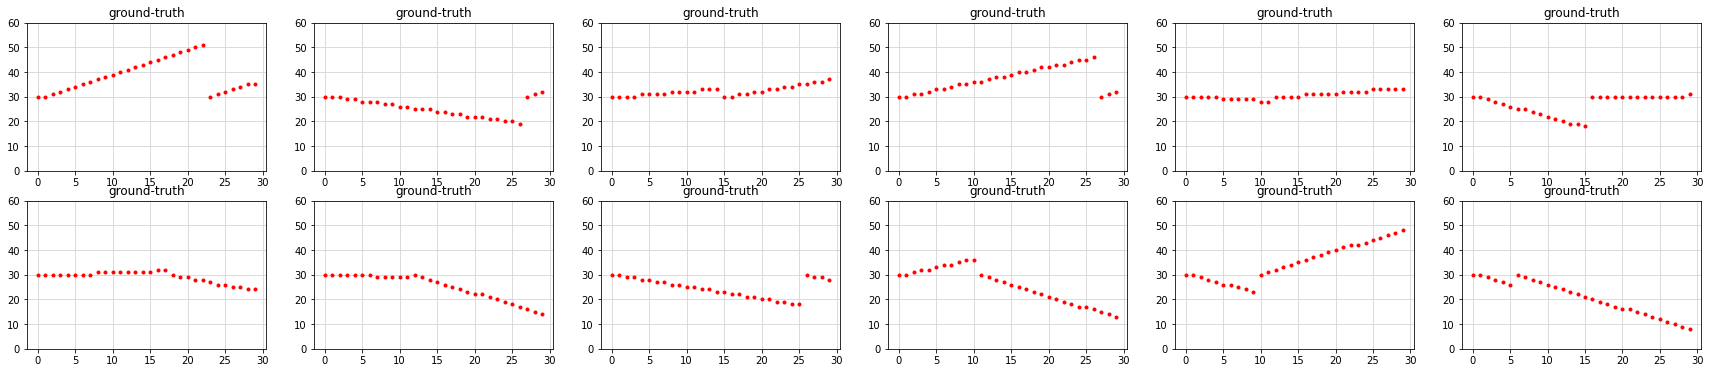

In [11]:
plt.subplots(figsize=(30, 12))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.ylim(0, 2*n)
    plt.grid(color='lightgray')
    plt.plot(torch.arange(n), generated[i, 0], '.')
    plt.title('generated')
    
plt.subplots(figsize=(30, 6))
for i in range(12):
    plt.subplot(2, 6, i+1)
    plt.ylim(0, 2*n)
    plt.grid(color='lightgray')
    plt.plot(torch.arange(n), ds[i].squeeze(), '.', color='red')
    plt.title('ground-truth')

## Improving global coherence

We can see that sometimes the model generates more than 1 discontinuity. This is not surprising, since this model stacks vanilla size 2 convolutions, and consequently has a receptive field of 6, given the 6 conv layers. We can increase the receptive field to 16 by introducing exponentially increasing dilations. 

In [12]:
class DilatedModel(nn.Module):
    
    def __init__(self, nb_classes, ks = 2, nc = 32):
        super().__init__()
        self.conv0 = nn.Conv1d(1, nc, kernel_size = 1)
        self.pad1 = ((ks-1) * 2, 0)
        self.conv1 = nn.Conv1d(nc, nc, kernel_size = ks, dilation = 2)
        self.pad2 = ((ks-1) * 4, 0)
        self.conv2 = nn.Conv1d(nc, nc, kernel_size = ks, dilation = 4)
        self.pad3 = ((ks-1) * 8, 0)
        self.conv3 = nn.Conv1d(nc, nc, kernel_size = ks, dilation = 8)
        self.pad4 = ((ks-1) * 16, 0)
        self.conv4 = nn.Conv1d(nc, nc, kernel_size = ks, dilation = 16)
        self.conv5 = nn.Conv1d(nc, nb_classes, kernel_size = 1)
        
    def forward(self, x):
        x = F.relu(self.conv0(F.pad(x, (1, -1))))
        x = F.relu(self.conv1(F.pad(x, self.pad1)))
        x = F.relu(self.conv2(F.pad(x, self.pad2)))
        x = F.relu(self.conv3(F.pad(x, self.pad3)))
        x = F.relu(self.conv4(F.pad(x, self.pad4)))
        x = self.conv5(x)
        return x.permute(0, 2, 1).contiguous()

200:060 loss 0.59720 best loss 0.56563: : 15800it [03:43, 70.63it/s]


Text(0.5, 1.0, 'cross entropy. best: 0.5656307935714722')

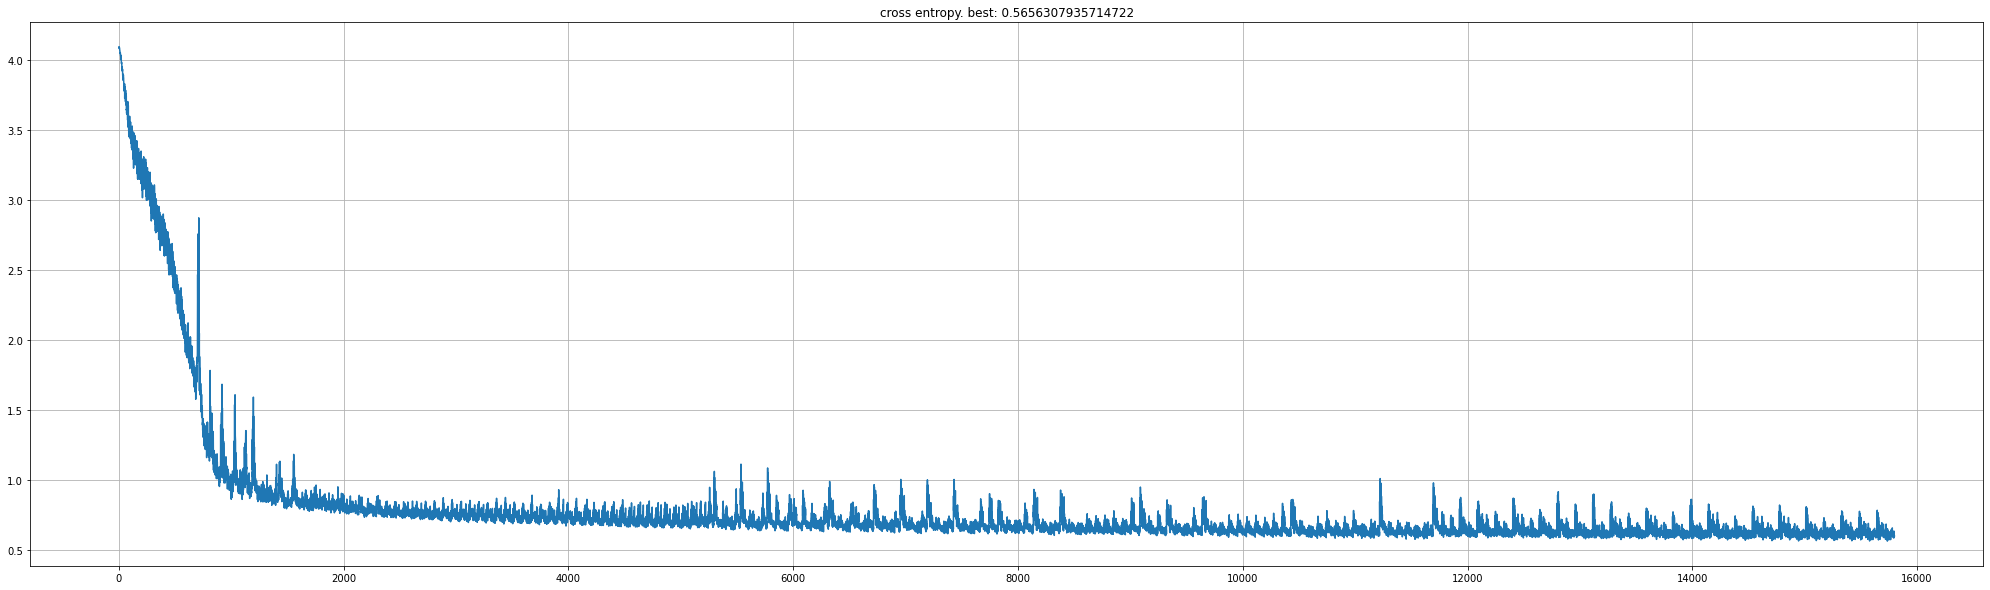

In [13]:
dilated_model = DilatedModel(2*n)
dilated_losses = train(dilated_model, n_epochs)

plt.figure(figsize=(35, 10))
plt.plot(dilated_losses)
plt.grid()
plt.title(f'cross entropy. best: {min(dilated_losses)}')

In [14]:
generated = sample(dilated_model)

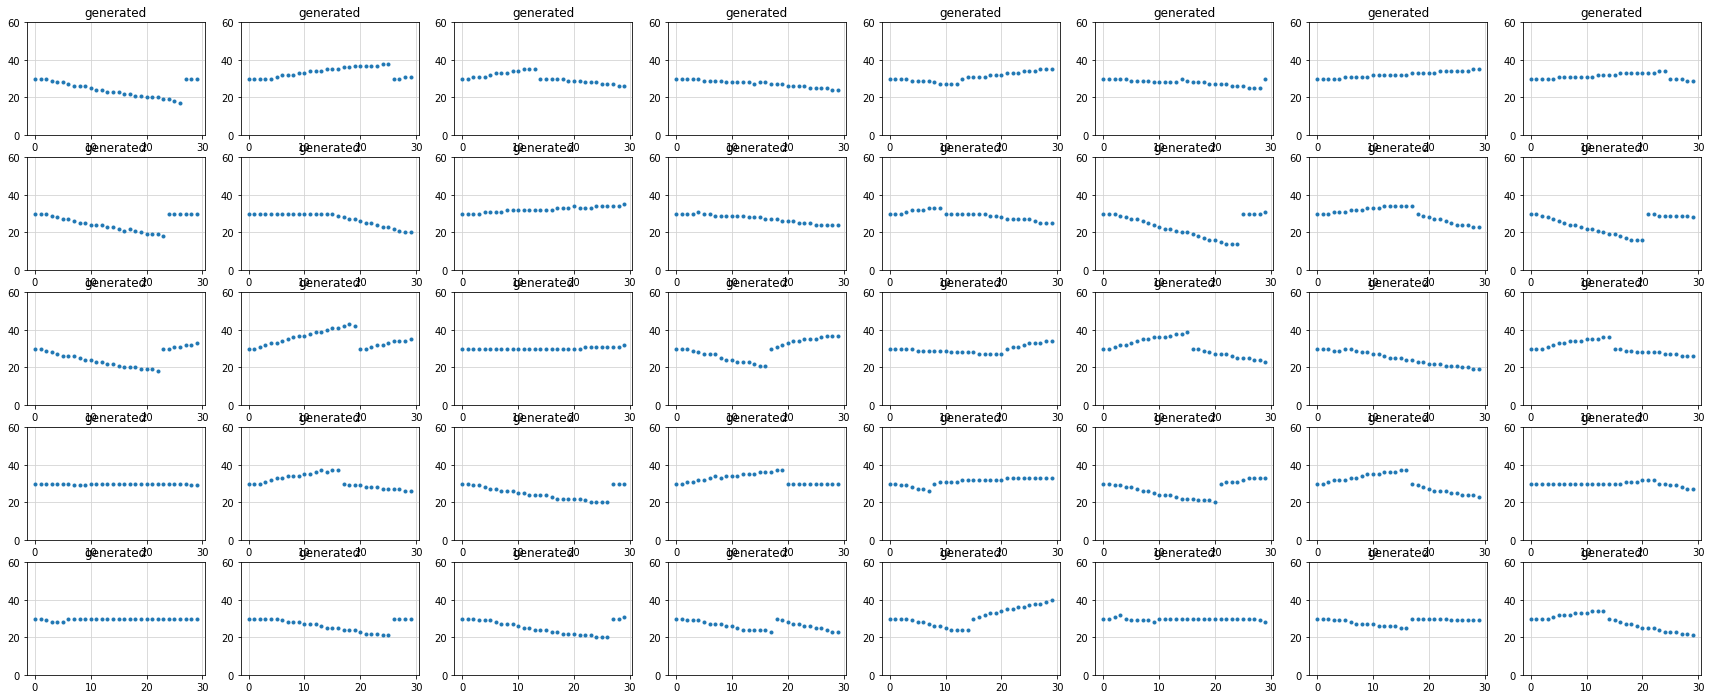

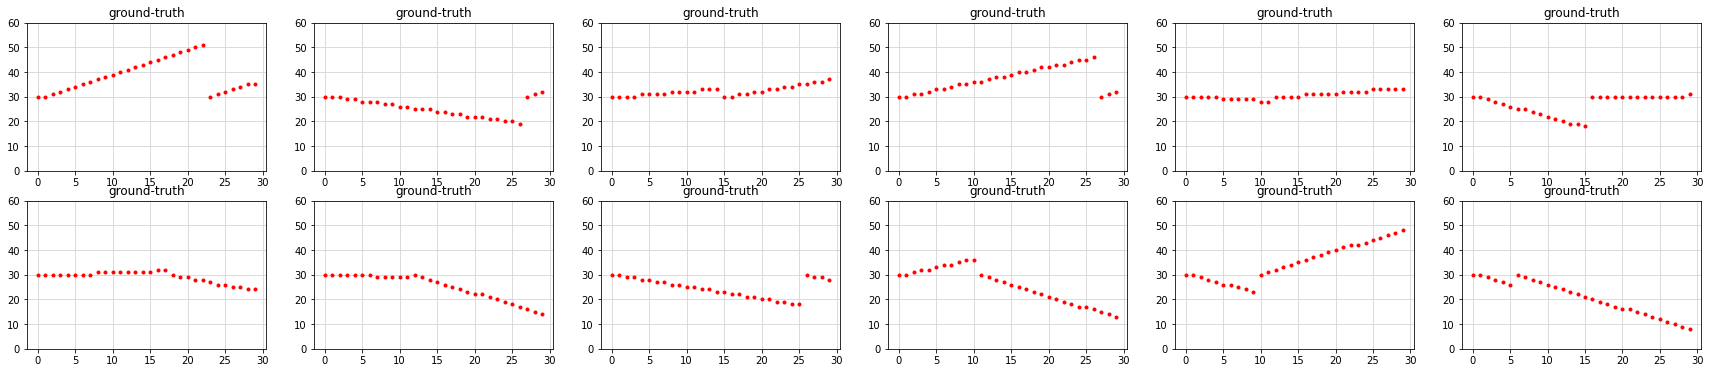

In [15]:
plt.subplots(figsize=(30, 12))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.ylim(0, 2*n)
    plt.grid(color='lightgray')
    plt.plot(torch.arange(n), generated[i, 0], '.')
    plt.title('generated')
    
plt.subplots(figsize=(30, 6))
for i in range(12):
    plt.subplot(2, 6, i+1)
    plt.ylim(0, 2*n)
    plt.grid(color='lightgray')
    plt.plot(torch.arange(n), ds[i].squeeze(), '.', color='red')
    plt.title('ground-truth')